In [20]:
import torch
t_version = str(torch.__version__)
s_src = f"https://pytorch-geometric.com/whl/torch-{t_version}.html"
sp_src = f"https://pytorch-geometric.com/whl/torch-{t_version}.html"
!pip install torch-scatter -f $s_src
!pip install torch-sparse -f $sp_src
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.6.0+cu124.html
  Preparing metadata (setup.py) ... done


In [21]:
import torch_geometric
torch_geometric.__version__

'2.6.1'

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch_scatter
import torch_geometric.nn as pyg_nn
import copy
import time
import networkx as nx
import requests
from torch_scatter import scatter
from torch_geometric.nn import MessagePassing
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from tqdm import trange
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

# Define Graph Neural Network Stack
class GraphNNStack(nn.Module):
    def __init__(self, input_features, hidden_features, output_classes, configuration, use_embeddings=False):
        super(GraphNNStack, self).__init__()
        conv_layer_class = self.select_conv_layer(configuration.model_type)
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(conv_layer_class(input_features, hidden_features))

        assert configuration.num_layers >= 1, 'Number of layers must be >= 1'
        for _ in range(configuration.num_layers - 1):
            self.conv_layers.append(conv_layer_class(configuration.heads * hidden_features, hidden_features))

        self.post_mp_layers = nn.Sequential(
            nn.Linear(configuration.heads * hidden_features, hidden_features),
            nn.Dropout(configuration.dropout),
            nn.Linear(hidden_features, output_classes)
        )

        self.dropout_rate = configuration.dropout
        self.num_layers = configuration.num_layers
        self.use_embeddings = use_embeddings

    def select_conv_layer(self, conv_type):
        if conv_type == 'GraphSage':
            return GraphSage
        elif conv_type == 'GAT':
            return GAT
        elif conv_type == 'GraphTransformer':
            return GraphTransformer
        elif conv_type == 'GINConv':
            return GINConv
        elif conv_type == 'GCN':
            return GCN
        elif conv_type == 'GraphContrastiveLearning':
            return GraphContrastiveLearning
        elif conv_type == 'AdaptiveGraphConv':
            return AdaptiveGraphConv
        else:
            raise ValueError(f"Unknown model type: {conv_type}")

    def forward_pass(self, graph_data):
        features, edge_indices, batches = graph_data.x, graph_data.edge_index, graph_data.batch
        for conv_layer in self.conv_layers:
            features = conv_layer(features, edge_indices)
            features = F.relu(features)
            features = F.dropout(features, p=self.dropout_rate, training=self.training)
        features = self.post_mp_layers(features)
        if self.use_embeddings:
            return features
        return F.log_softmax(features, dim=1)

    def calculate_loss(self, predictions, labels):
        return F.nll_loss(predictions, labels)

In [23]:
class GraphSage(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize=True, bias=True, **kwargs):
        super(GraphSage, self).__init__(aggr='mean', **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin = nn.Linear(in_channels, out_channels, bias=bias)
        self.agg_lin = nn.Linear(in_channels + out_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.agg_lin.reset_parameters()

    def forward(self, x, edge_index, size=None):
        out = self.propagate(edge_index, x=x, size=size)
        out = self.agg_lin(torch.cat([x, out], dim=-1))

        if self.normalize:
            out = F.normalize(out, p=2)

        return out

    def message(self, x_j):
        return x_j

    def aggregate(self, inputs, index, dim_size=None):
        return scatter(inputs, index, dim=self.node_dim, reduce='mean')

    def update(self, inputs):
        return self.lin(inputs)

In [24]:
class GAT(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=2, negative_slope=0.2, dropout=0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = nn.Linear(self.in_channels, self.out_channels * self.heads)
        self.lin_r = self.lin_l  # Assuming self.lin_r is the same as self.lin_l
        self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size=None):
        H, C = self.heads, self.out_channels
        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)
        alpha_l = self.att_l * x_l
        alpha_r = self.att_r * x_r
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), size=size)
        out = out.reshape(-1, H * C)
        return out

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        alpha = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)
        if ptr is not None:
            att_weight = F.softmax(alpha, ptr)
        else:
            att_weight = torch_geometric.utils.softmax(alpha, index)
        att_weight = F.dropout(att_weight, p=self.dropout, training=self.training)
        return att_weight * x_j

    def aggregate(self, inputs, index, dim_size=None):
        return torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce='sum')

In [25]:
class GraphTransformer(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, dropout=0.0, normalize=True, bias=True, **kwargs):
        super(GraphTransformer, self).__init__(aggr='add', **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.dropout = dropout
        self.normalize = normalize

        self.lin_q = nn.Linear(in_channels, out_channels * heads, bias=bias)
        self.lin_k = nn.Linear(in_channels, out_channels * heads, bias=bias)
        self.lin_v = nn.Linear(in_channels, out_channels * heads, bias=bias)
        self.lin_out = nn.Linear(out_channels * heads, out_channels, bias=bias)

        self.attention = None

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_q.reset_parameters()
        self.lin_k.reset_parameters()
        self.lin_v.reset_parameters()
        self.lin_out.reset_parameters()

    def forward(self, x, edge_index, size=None):
        out = self.propagate(edge_index, x=x, size=size)
        out = self.lin_out(out)

        if self.normalize:
            out = F.normalize(out, p=2)

        return out

    def message(self, x_j, x_i, edge_index, size_i):
        q = self.lin_q(x_i).view(-1, self.heads, self.out_channels)
        k = self.lin_k(x_j).view(-1, self.heads, self.out_channels)
        v = self.lin_v(x_j).view(-1, self.heads, self.out_channels)

        # Compute attention scores
        score = (q * k).sum(dim=-1) / self.out_channels ** 0.5
        score = F.leaky_relu(score, negative_slope=0.2)
        score = F.softmax(score, dim=-1)
        score = F.dropout(score, p=self.dropout, training=self.training)

        self.attention = score

        out = v * score.view(-1, self.heads, 1)
        out = out.view(-1, self.heads * self.out_channels)

        return out

    def aggregate(self, inputs, index, dim_size=None):
        return scatter(inputs, index, dim=self.node_dim, reduce='mean')

    def update(self, inputs):
        return inputs


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class GINConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GINConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels)
        )
        self.eps = nn.Parameter(torch.Tensor([0]))

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Start propagating messages.
        return self.mlp((1 + self.eps) * x + self.propagate(edge_index, x=x))

    def message(self, x_j):
        return x_j

    def update(self, aggr_out):
        return aggr_out

class GIN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GIN, self).__init__()
        self.conv1 = GINConv(in_channels, hidden_channels)
        self.conv2 = GINConv(hidden_channels, hidden_channels)
        self.conv3 = GINConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class GCN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, x, edge_index):
        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Normalize node features.
        row, col = edge_index
        deg = torch.bincount(row, minlength=x.size(0)).float()
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # Step 5: Normalize node features.
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # Step 6: Return new node embeddings.
        return aggr_out


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
import torch_geometric.utils
import torch_scatter

class GraphContrastiveLearning(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, dropout=0.0):
        super(GraphContrastiveLearning, self).__init__(aggr='add')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.dropout = dropout

        self.lin = nn.Linear(in_channels, out_channels)
        self.projection_head = nn.Sequential(
            nn.Linear(out_channels, out_channels),
            nn.ReLU(inplace=True),
            nn.Linear(out_channels, out_channels)
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        for layer in self.projection_head:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

    def forward(self, x, edge_index):
        x = self.lin(x)
        x = self.propagate(edge_index, x=x)
        return self.projection_head(x)

    def message(self, x_j):
        return x_j

    def contrastive_loss(self, z_i, z_j):
        batch_size = z_i.size(0)
        z_i = F.normalize(z_i, dim=-1)
        z_j = F.normalize(z_j, dim=-1)

        pos_score = torch.sum(z_i * z_j, dim=-1)
        neg_score = torch.mm(z_i, z_j.t())

        pos_loss = -torch.log(torch.exp(pos_score) / (torch.exp(neg_score).sum(dim=-1) + 1e-6)).mean()
        return pos_loss

In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class AdaptiveGraphConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(AdaptiveGraphConv, self).__init__(aggr='add')  # Add aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.weight = torch.nn.Parameter(torch.Tensor(in_channels, out_channels))
        self.reset_parameters()

        # Add batch normalization
        self.bn = torch.nn.BatchNorm1d(out_channels)

        # Add dropout layer
        self.dropout = torch.nn.Dropout(p=0.5)

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        self.lin.reset_parameters()

    def forward(self, x, edge_index):
        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Normalize edge weights.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 5: Apply batch normalization and dropout
        out = self.bn(out)
        out = self.dropout(out)

        return out

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # Return new node embeddings.
        return aggr_out

In [30]:
import torch.optim as optim
def setup_optimizer_and_scheduler(configuration, model_params):
    weight_decay = configuration.weight_decay
    trainable_params = filter(lambda p: p.requires_grad, model_params)

    if configuration.optimizer == 'adam':
        optimizer = optim.Adam(trainable_params, lr=configuration.learning_rate, weight_decay=weight_decay)
    elif configuration.optimizer == 'sgd':
        optimizer = optim.SGD(trainable_params, lr=configuration.learning_rate, momentum=0.95, weight_decay=weight_decay)
    elif configuration.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(trainable_params, lr=configuration.learning_rate, weight_decay=weight_decay)
    elif configuration.optimizer == 'adagrad':
        optimizer = optim.Adagrad(trainable_params, lr=configuration.learning_rate, weight_decay=weight_decay)

    if configuration.scheduler == 'none':
        return None, optimizer
    elif configuration.scheduler == 'step':
        scheduler = StepLR(optimizer, step_size=configuration.decay_step, gamma=configuration.decay_rate)
    elif configuration.scheduler == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=configuration.restart_interval)

    return scheduler, optimizer

In [31]:
import time
import numpy as np
import torch
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate_metrics(predictions, labels):
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted', zero_division=0)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)
    f1 = f1_score(labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

# Train the Model
def train_model(graph_dataset, configuration):
    print("Node task. Train set size:", np.sum(graph_dataset[0]['train_mask'].numpy()))
    train_loader = DataLoader(graph_dataset, batch_size=configuration.batch_size, shuffle=True)
    test_loader = DataLoader(graph_dataset, batch_size=configuration.batch_size, shuffle=False)

    model = GraphNNStack(graph_dataset.num_node_features, configuration.hidden_dim, graph_dataset.num_classes, configuration)
    scheduler, optimizer = setup_optimizer_and_scheduler(configuration, model.parameters())

    losses = []
    test_accuracies = []
    for epoch in range(configuration.epochs):
        total_loss = 0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            predictions = model.forward_pass(batch)
            labels = batch.y
            predictions = predictions[batch.train_mask]
            labels = labels[batch.train_mask]
            loss = model.calculate_loss(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
            test_accuracy, _, _, _, _ = evaluate_model(test_loader, model)
            test_accuracies.append(test_accuracy)
        else:
            test_accuracies.append(test_accuracies[-1])

    return test_accuracies, losses, model

# Evaluate the Model
def evaluate_model(loader, model, validation=False):
    model.eval()
    correct_predictions = 0
    all_predictions = []
    all_labels = []

    for graph_data in loader:
        with torch.no_grad():
            predictions = model.forward_pass(graph_data).max(dim=1)[1]
            labels = graph_data.y
        mask = graph_data.val_mask if validation else graph_data.test_mask
        predictions = predictions[mask]
        labels = labels[mask]
        all_predictions.append(predictions)
        all_labels.append(labels)
        correct_predictions += predictions.eq(labels).sum().item()

    total_samples = 0
    for graph_data in loader.dataset:
        total_samples += torch.sum(graph_data.val_mask if validation else graph_data.test_mask).item()

    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    accuracy, precision, recall, f1 = evaluate_metrics(all_predictions, all_labels)

    return correct_predictions / total_samples, accuracy, precision, recall, f1

class Config:
    def __init__(self, parameters):
        self.__dict__.update(parameters)

## Cora Dataset

Training model: GraphSage
Node task. Train set size: 140
Calculating metrics for the best model...
Model: GraphSage
Dataset: cora
Max Accuracy: 0.7900
Min Loss: 0.1041
Hit Ratio: 0.7620
Precision: 0.7814
Recall: 0.7620
F1 Score: 0.7650
Time Taken: 100.09 seconds
--------------------------------------
Training model: GAT
Node task. Train set size: 140
Calculating metrics for the best model...
Model: GAT
Dataset: cora
Max Accuracy: 0.7870
Min Loss: 0.0272
Hit Ratio: 0.7540
Precision: 0.7700
Recall: 0.7540
F1 Score: 0.7554
Time Taken: 54.57 seconds
--------------------------------------
Training model: GraphTransformer
Node task. Train set size: 140
Calculating metrics for the best model...
Model: GraphTransformer
Dataset: cora
Max Accuracy: 0.7190
Min Loss: 0.1434
Hit Ratio: 0.7030
Precision: 0.7335
Recall: 0.7030
F1 Score: 0.7026
Time Taken: 135.40 seconds
--------------------------------------
Training model: GINConv
Node task. Train set size: 140
Calculating metrics for the best model

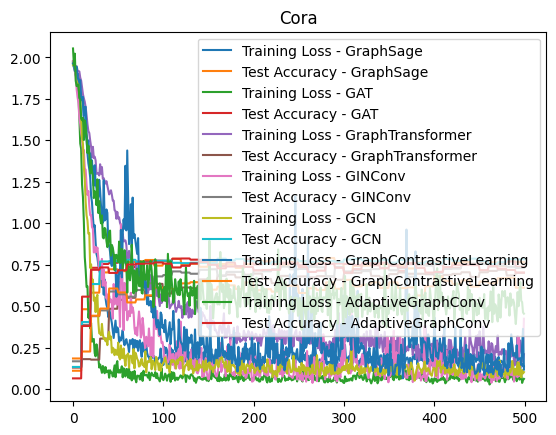

In [ ]:
def main():
    configurations = [
        {
            'model_type': 'GraphSage',
            'dataset': 'cora',
            'num_layers': 2, 
            'heads': 1,
            'batch_size': 32,
            'hidden_dim': 32,  
            'dropout': 0.5,
            'epochs': 500,  
            'optimizer': 'adam',
            'scheduler': 'none',
            'restart_interval': 0,
            'weight_decay': 5e-3,
            'learning_rate': 0.01
        },
    ]

    for config_dict in configurations:
        config = Config(config_dict)
        for model_name in ['GraphSage', 'GAT', 'GraphTransformer', 'GINConv', 'GCN', 'GraphContrastiveLearning', 'AdaptiveGraphConv']:
            config.model_type = model_name
            print(f"Training model: {model_name}")

            if model_name == 'GAT':
                config.heads = 2
            else:
                config.heads = 1

            if config.dataset == 'cora':
                graph_dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset")

            start_time = time.time()
            test_accuracies, losses, best_model = train_model(graph_dataset, config)
            end_time = time.time()
            elapsed_time = end_time - start_time

            print("Calculating metrics for the best model...")
            test_loader = DataLoader(graph_dataset, batch_size=config.batch_size, shuffle=False)
            hit_ratio, accuracy, precision, recall, f1 = evaluate_model(test_loader, best_model, validation=False)

            print(f"Model: {model_name}")
            print(f"Dataset: {config.dataset}")
            print(f"Max Accuracy: {max(test_accuracies):.4f}")
            print(f"Min Loss: {min(losses):.4f}")
            print(f"Hit Ratio: {hit_ratio:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Time Taken: {elapsed_time:.2f} seconds")
            print("--------------------------------------")

            plt.title(graph_dataset.name)
            plt.plot(losses, label=f"Training Loss - {config.model_type}")
            plt.plot(test_accuracies, label=f"Test Accuracy - {config.model_type}")
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

##Citeseer Dataset

Training model: GraphSage
Node task. Train set size: 120
Calculating metrics for the best model...
Model: GraphSage
Dataset: citeseer
Max Accuracy: 0.6600
Min Loss: 0.0925
Hit Ratio: 0.6200
Precision: 0.6588
Recall: 0.6200
F1 Score: 0.6308
Time Taken: 282.31 seconds
--------------------------------------
Training model: GAT
Node task. Train set size: 120
Calculating metrics for the best model...
Model: GAT
Dataset: citeseer
Max Accuracy: 0.6590
Min Loss: 0.0262
Hit Ratio: 0.6350
Precision: 0.6486
Recall: 0.6350
F1 Score: 0.6394
Time Taken: 118.76 seconds
--------------------------------------
Training model: GraphTransformer
Node task. Train set size: 120
Calculating metrics for the best model...
Model: GraphTransformer
Dataset: citeseer
Max Accuracy: 0.6190
Min Loss: 0.1023
Hit Ratio: 0.6120
Precision: 0.6351
Recall: 0.6120
F1 Score: 0.6192
Time Taken: 327.26 seconds
--------------------------------------
Training model: GINConv
Node task. Train set size: 120
Calculating metrics for t

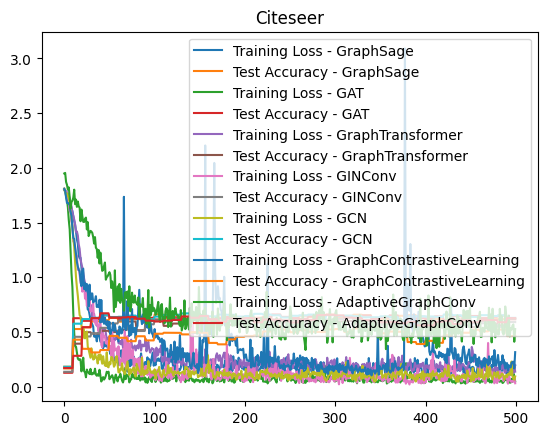

In [ ]:
def main():

    configurations = [
        {
            'model_type': 'GraphSage',
            'dataset': 'citeseer',
            'num_layers': 2, 
            'heads': 1,
            'batch_size': 32,
            'hidden_dim': 32,  
            'dropout': 0.5,
            'epochs': 500,  
            'optimizer': 'adam',
            'scheduler': 'none',
            'restart_interval': 0,
            'weight_decay': 5e-3,
            'learning_rate': 0.01
        },
    ]

    for config_dict in configurations:
        config = Config(config_dict)
        for model_name in ['GraphSage', 'GAT', 'GraphTransformer', 'GINConv', 'GCN', 'GraphContrastiveLearning', 'AdaptiveGraphConv']:
            config.model_type = model_name
            print(f"Training model: {model_name}")

            if model_name == 'GAT':
                config.heads = 2
            else:
                config.heads = 1

            if config.dataset == 'citeseer':
                graph_dataset = Planetoid(root='/tmp/citeseer', name='Citeseer')
            else:
                raise NotImplementedError("Unknown dataset")

            start_time = time.time()
            test_accuracies, losses, best_model = train_model(graph_dataset, config)
            end_time = time.time()
            elapsed_time = end_time - start_time

            print("Calculating metrics for the best model...")
            test_loader = DataLoader(graph_dataset, batch_size=config.batch_size, shuffle=False)
            hit_ratio, accuracy, precision, recall, f1 = evaluate_model(test_loader, best_model, validation=False)

            print(f"Model: {model_name}")
            print(f"Dataset: {config.dataset}")
            print(f"Max Accuracy: {max(test_accuracies):.4f}")
            print(f"Min Loss: {min(losses):.4f}")
            print(f"Hit Ratio: {hit_ratio:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Time Taken: {elapsed_time:.2f} seconds")
            print("--------------------------------------")

            plt.title(graph_dataset.name)
            plt.plot(losses, label=f"Training Loss - {config.model_type}")
            plt.plot(test_accuracies, label=f"Test Accuracy - {config.model_type}")
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()

##Pubmed Dataset

Training model: GraphSage
Node task. Train set size: 60
Calculating metrics for the best model...
Model: GraphSage
Dataset: pubmed
Max Accuracy: 0.7800
Min Loss: 0.0075
Hit Ratio: 0.7180
Precision: 0.7366
Recall: 0.7180
F1 Score: 0.7134
Time Taken: 351.86 seconds
--------------------------------------
Training model: GAT
Node task. Train set size: 60
Calculating metrics for the best model...
Model: GAT
Dataset: pubmed
Max Accuracy: 0.7750
Min Loss: 0.0352
Hit Ratio: 0.7740
Precision: 0.7738
Recall: 0.7740
F1 Score: 0.7737
Time Taken: 317.58 seconds
--------------------------------------
Training model: GraphTransformer
Node task. Train set size: 60
Calculating metrics for the best model...
Model: GraphTransformer
Dataset: pubmed
Max Accuracy: 0.4130
Min Loss: 1.0689
Hit Ratio: 0.4130
Precision: 0.1706
Recall: 0.4130
F1 Score: 0.2414
Time Taken: 486.22 seconds
--------------------------------------
Training model: GINConv
Node task. Train set size: 60
Calculating metrics for the best mo

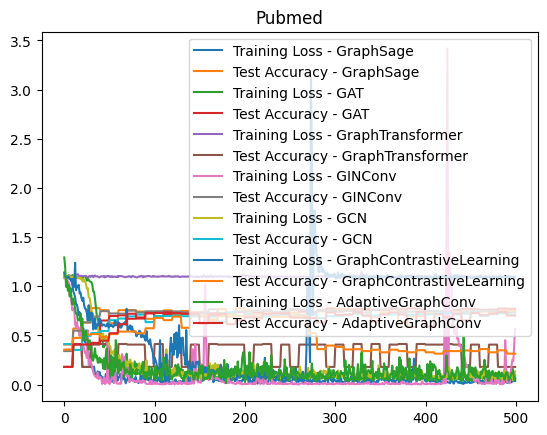

In [ ]:
def main():
    configurations = [
        {
            'model_type': 'GraphSage',
            'dataset': 'pubmed',
            'num_layers': 2, 
            'heads': 1,
            'batch_size': 32,
            'hidden_dim': 32,  
            'dropout': 0.5,
            'epochs': 500,  
            'optimizer': 'adam',
            'scheduler': 'none',
            'restart_interval': 0,
            'weight_decay': 5e-3,
            'learning_rate': 0.01
        },
    ]

    for config_dict in configurations:
        config = Config(config_dict)
        for model_name in ['GraphSage', 'GAT', 'GraphTransformer', 'GINConv', 'GCN', 'GraphContrastiveLearning', 'AdaptiveGraphConv']:
            config.model_type = model_name
            print(f"Training model: {model_name}")

            if model_name == 'GAT':
                config.heads = 2
            else:
                config.heads = 1

            if config.dataset == 'pubmed':
                graph_dataset = Planetoid(root='/tmp/pubmed', name='Pubmed')
            else:
                raise NotImplementedError("Unknown dataset")

            start_time = time.time()
            test_accuracies, losses, best_model = train_model(graph_dataset, config)
            end_time = time.time()
            elapsed_time = end_time - start_time

            print("Calculating metrics for the best model...")
            test_loader = DataLoader(graph_dataset, batch_size=config.batch_size, shuffle=False)
            hit_ratio, accuracy, precision, recall, f1 = evaluate_model(test_loader, best_model, validation=False)

            print(f"Model: {model_name}")
            print(f"Dataset: {config.dataset}")
            print(f"Max Accuracy: {max(test_accuracies):.4f}")
            print(f"Min Loss: {min(losses):.4f}")
            print(f"Hit Ratio: {hit_ratio:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1 Score: {f1:.4f}")
            print(f"Time Taken: {elapsed_time:.2f} seconds")
            print("--------------------------------------")

            plt.title(graph_dataset.name)
            plt.plot(losses, label=f"Training Loss - {config.model_type}")
            plt.plot(test_accuracies, label=f"Test Accuracy - {config.model_type}")
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main()